# Map human scRNA-seq kidney on mouse Visium kidney.

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
fld = os.path.join(home, 'kidney_dataset')
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'human_kidney_map.h5ad')
ad_sc = sc.read_h5ad(path)
# Convert mouse genes to human convention
ad_sc.var.index = ad_sc.var.index.str.upper()
ad_sc.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'visium_mouse_kidney_filtered.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sc.var_names_make_unique()

# filter obs in ROI
mask = ad_sp.obs.in_ROI == True
ad_sp.obs = ad_sp.obs[mask]

# there are no empty voxel
sums = np.sum(ad_sp.X, axis=1).A1
assert np.sum(sums == 0) == 0

# take list of HV genes
assert ad_sc.var.highly_variable.all()
hv_genes = ad_sc.var.index.values

# Convert mouse genes to human convention
ad_sp.var.index = ad_sp.var.index.str.upper()

# Only shared genes between visium and sn
mask = ad_sp.var.index.isin(hv_genes)
ad_sp = ad_sp[:, mask]
ad_sp

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 1438 × 1654
    obs: 'in_ROI', 'frame_x', 'frame_y', 'x_fu', 'y_fu', 'x_hi', 'y_hi', 'x_lo', 'y_lo'
    var: 'gene_ids'

In [5]:
'Annotate marker genes on Visium'
mask = ad_sc.var.marker
marker_genes = ad_sc.var[mask].index.values
ad_sp.var['marker'] = ad_sp.var.index.isin(marker_genes)
ad_sp.var['marker'].sum()

Trying to set attribute `.var` of view, copying.


781

In [6]:
'Restrict ad_sc on shared genes and reindex as ad_sp'
hv_genes = ad_sp.var.index.values
mask = ad_sc.var.index.isin(hv_genes)
ad_sc = ad_sc[:, mask]
ad_sc.var = ad_sc.var.reindex(ad_sp.var.index)

***
## Feature selection

In [7]:
# 'Compute gene sparsity across datasets'
# sparsity_sc = np.sum((ad_sc.X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp.X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On HV genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [8]:
# 'Filter genes'
# # take out genes sparse in sc and not in Visium
# mask_1 = sparsity_sc > 0.9
# mask_2 = sparsity_sp < 0.5
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = mask

# # take out super sparse genes
# mask_1 = sparsity_sc > 0.97
# mask_2 = sparsity_sp > 0.97
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

# # take out genes sparse in Visium and not in sc
# mask_1 = sparsity_sc < 0.5
# mask_2 = sparsity_sp > 0.6
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

In [9]:
# sparsity_sc = np.sum((ad_sc[:, total_mask].X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp[:, total_mask].X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On ' + str(total_mask.sum()) + ' genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5); 

In [10]:
ad_sc_fl = ad_sc
ad_sp_fl = ad_sp

known_markers = [
    'CYRAB', 'NAPSA', 'NDUFB8', 'COXBA', 'HBB-BS', 'SERPINA1F'
]

[gene in list(ad_sc_fl.var.index.values) for gene in known_markers]

[False, True, False, False, False, False]

In [11]:
# sparsity_sc = np.sum(ad_sc_fl.X, axis=0) / np.sum(ad_sc.X)
# sparsity_sp = np.sum(ad_sp_fl.X.toarray(), axis=0) / np.sum(ad_sp.X)
# # plt.xscale('log')
# # plt.yscale('log')
# # plt.xlabel('Sparsity (scRNAseq)');
# # plt.ylabel('Sparsity (Visium)');
# # plt.title('On HV genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [12]:
# mask = ad_sc.var.marker
# ad_sc_marker = ad_sc[:, mask]
# mask = ad_sp.var.marker
# ad_sp_marker = ad_sp[:, mask]
# assert ad_sp_marker.var.index.equals(ad_sc_marker.var.index)

In [13]:
# sparsity_sc = np.sum((ad_sc_marker.X == 0), axis=0) / ad_sc_marker.n_obs
# sparsity_sp = np.sum((ad_sp_marker.X.toarray() == 0), axis=0) / ad_sp_marker.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On marker genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

***

In [14]:
'Allocate matrices and select device'
S = np.array(ad_sc_fl.X, dtype='float32')
G = np.array(ad_sp_fl.X.toarray(), dtype='float32')
d = np.zeros(ad_sp_fl.n_obs)
device = torch.device('cuda:0')  # for gpu

In [15]:
'Define Tangram hyperparameters'
## TODO pars not in manuscript
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
    'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
    'lambda_f_reg' : 1,  # regularizer: filter values are Boolean
}
learning_rate = 0.1
num_epochs = 6000

- Is `MapperConstrained` the same as `Mapper` w/o filter? NO: il filtro c'e' sempre negli altri terms della loss
-  Forse chiamarlo `MapperWithFilter`

In [16]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
# mapper = mapping.mapping_optimizer.Mapper(
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, 
    **hyperparm, 
#     target_count = space_data.obs.cell_count.sum()
)

#### TODO
- Save history of loss terms in mapping object.

In [17]:
'Train Tangram'
# The output are the various terms in the loss function (see manuscript).
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (ie the hyperaparameter)
output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

nan 0.41284236311912537 0.07467886805534363 nan 3559.8935546875
nan 0.6899529695510864 0.16864871978759766 nan 69.45592498779297
nan 0.6898444294929504 0.18544505536556244 nan 27.996767044067383
nan 0.6893160343170166 0.19027560949325562 nan 15.86526870727539
nan 0.6888515949249268 0.19274510443210602 nan 10.443967819213867
nan 0.6884737610816956 0.1945289820432663 nan 7.487433433532715
nan 0.6882578134536743 0.195457324385643 nan 5.672944068908691
nan 0.6879597306251526 0.19633936882019043 nan 4.467583179473877
nan 0.6877663135528564 0.19690290093421936 nan 3.6198034286499023
nan 0.6876107454299927 0.19742411375045776 nan 2.9981141090393066
nan 0.6873515248298645 0.1980060338973999 nan 2.5273237228393555
nan 0.6871430277824402 0.19851404428482056 nan 2.160184621810913
nan 0.6868744492530823 0.19905559718608856 nan 1.868011236190796
nan 0.6866430044174194 0.1995655596256256 nan 1.631216287612915
nan 0.6865589022636414 0.19976112246513367 nan 1.4363045692443848
nan 0.6864389777183533 0.

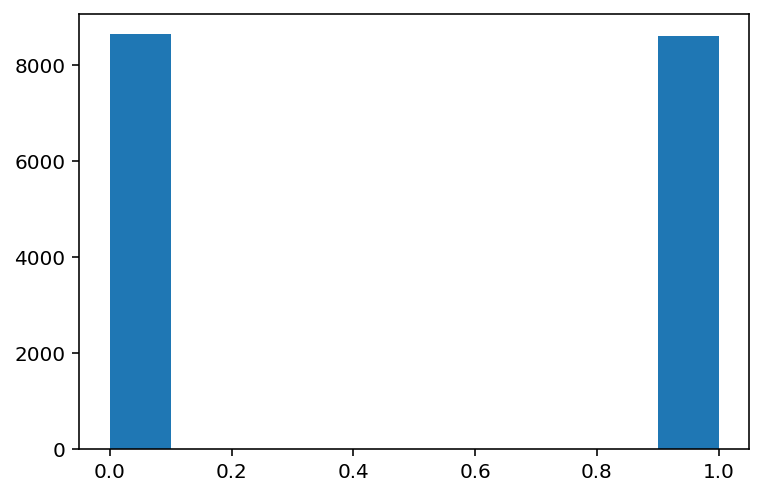

In [30]:
plt.hist(F_out);

***
## Filter analysis

#### TODO 
- Filter analysis: how many cells have been mapped? 
- What are the cell type proportions?

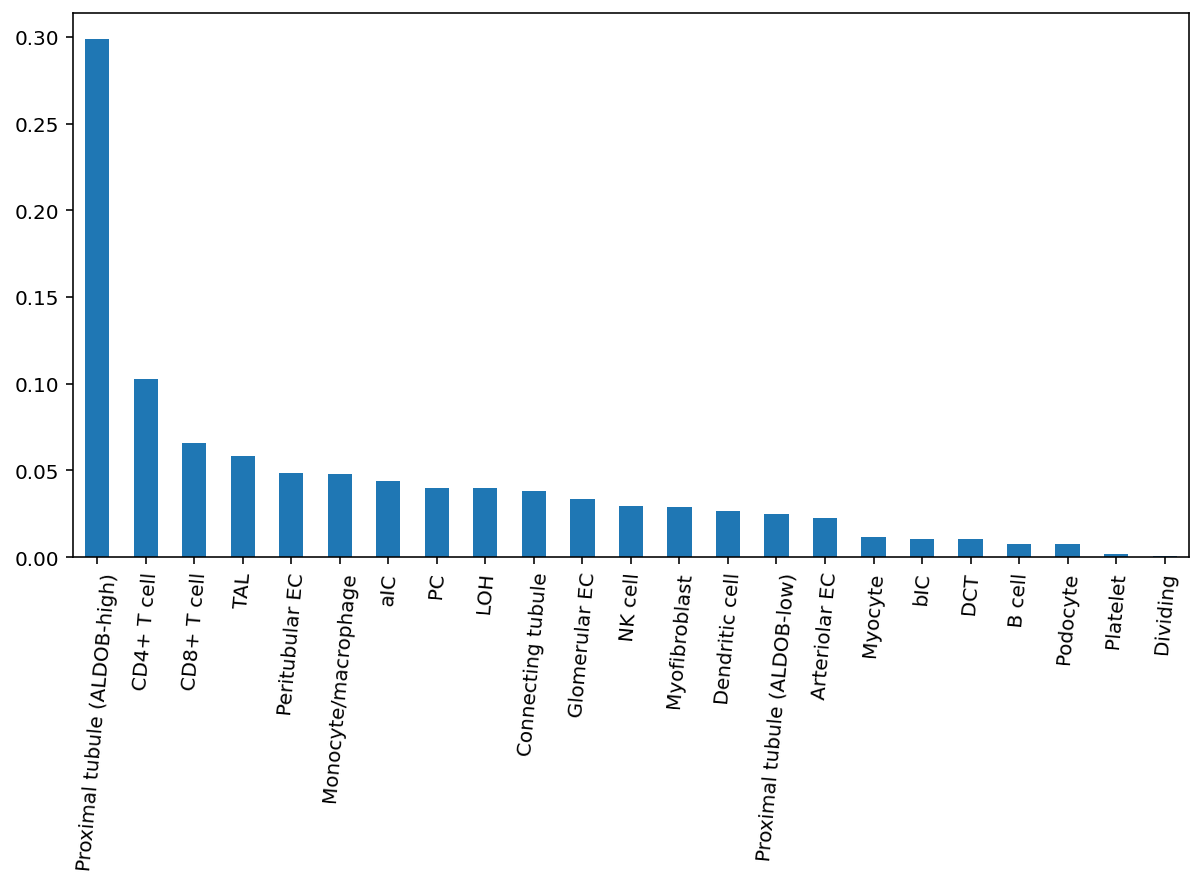

In [75]:
fracs = ad_sc.obs['subsampling.label'].value_counts() / ad_sc.n_obs
fracs.plot(kind='bar', rot=85, figsize=(10, 5));

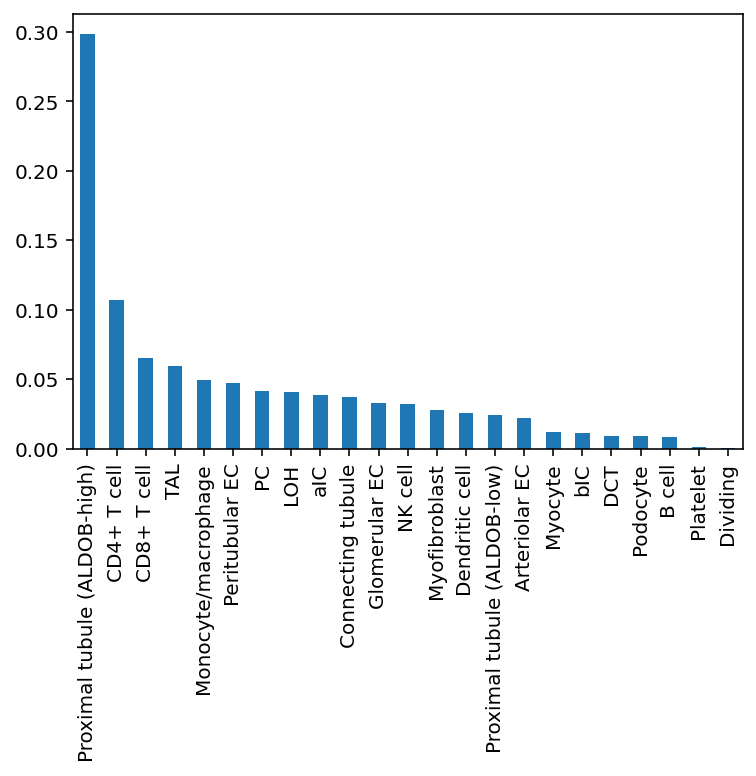

In [76]:
mask = F_out > 0.5
fracs_2 = ad_sc[mask, :].obs['subsampling.label'].value_counts() / ad_sc[mask, :].n_obs
fracs_2.plot(kind='bar');

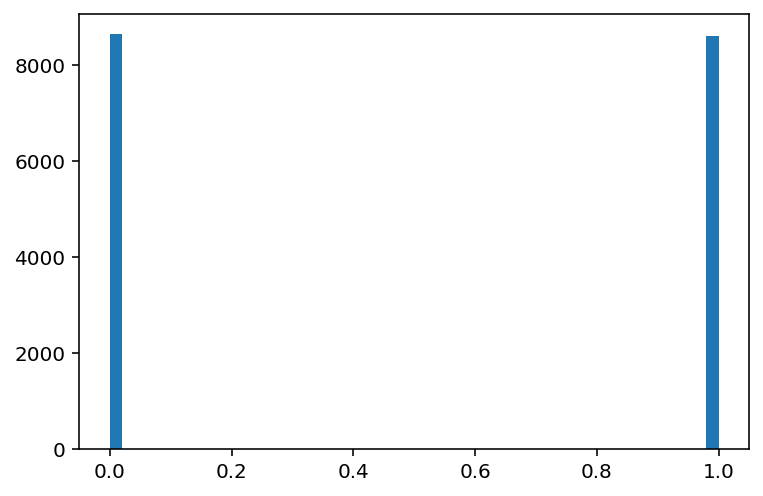

In [83]:
plt.hist(F_out, bins=50);

***

In [43]:
mask = F_out > .5
ad_sc[]

AnnData object with n_obs × n_vars = 17247 × 1654
    obs: 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'samples', 'predicted.id', 'prediction.score.Intercalated.cell_SPINK1.high', 'prediction.score.Loop.of.Henle.Thick.ascending.limb.', 'prediction.score.Loop.of.Henle_SPP1.high', 'prediction.score.Epithelial_cell_NUPR1.high', 'prediction.score.Distal.tubule.cell', 'prediction.score.Principle.cell', 'prediction.score.Ureteric.epithelial.cell', 'prediction.score.Mast.cell', 'prediction.score.T.cell', 'prediction.score.Proximal.tubule.cell_MT1G.high', 'prediction.score.Fenestrated.endothelial.cell_SELE.high', 'prediction.score.Macrophage', 'prediction.score.Loop.of.Henle_SFN.high', 'prediction.score.Proximal.tubule.cell_ALDOB.high', 'prediction.score.Conventional.dendritic.cell', 'prediction.score.Fenestrated.endothelial.cell_EMCN.high', 'prediction.score.Glomerular.endothelial.cell_AQP1.high', 'prediction.score.Intercalated.cell_SLC26A4.high', 'prediction.score.Myocyte', 'prediction.score

In [18]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(ad_sc.obs['subsampling.label'])
prob_assign = mapping.utils.transfer_annotations_prob(output, df_classes)
prob_assign.head()

,Myofibroblast,Podocyte,LOH,Monocyte/macrophage,Dendritic cell,TAL,NK cell,Arteriolar EC,Peritubular EC,Glomerular EC,...,Myocyte,aIC,CD8+ T cell,Proximal tubule (ALDOB-high),DCT,B cell,bIC,CD4+ T cell,PC,Dividing
0,0.000065,0.000002,0.000051,0.000072,0.000008,0.000028,0.000139,0.000065,0.000016,0.000328,...,0.000004,0.000602,0.000056,0.000301,0.000066,0.000036,0.000006,0.000098,0.000248,0.000004
1,1.357747,0.072746,1.045932,0.136884,0.073289,1.231345,0.116071,0.046280,0.249319,0.138907,...,0.000007,0.157935,1.395552,2.751041,0.000005,0.002382,0.018862,0.082376,2.372491,0.000001
2,0.281915,0.144261,0.377689,0.516797,0.224528,0.741699,0.588109,0.221096,2.463991,1.275523,...,0.151534,0.298865,2.547476,8.007567,0.056478,0.057439,1.095678,0.607993,0.102466,0.025810
3,0.053098,0.082208,0.021648,0.021734,0.005571,0.020841,0.064353,0.025295,0.030178,0.014145,...,0.000006,0.149331,1.009969,0.071743,0.016890,0.004657,0.009902,0.061389,0.329223,0.001489
4,1.271562,0.090161,1.210518,0.359898,0.435004,1.040621,0.529144,0.197270,0.566157,0.368725,...,0.225790,3.218641,1.983693,10.312053,0.212035,0.134679,0.044488,4.883576,0.157616,0.004715


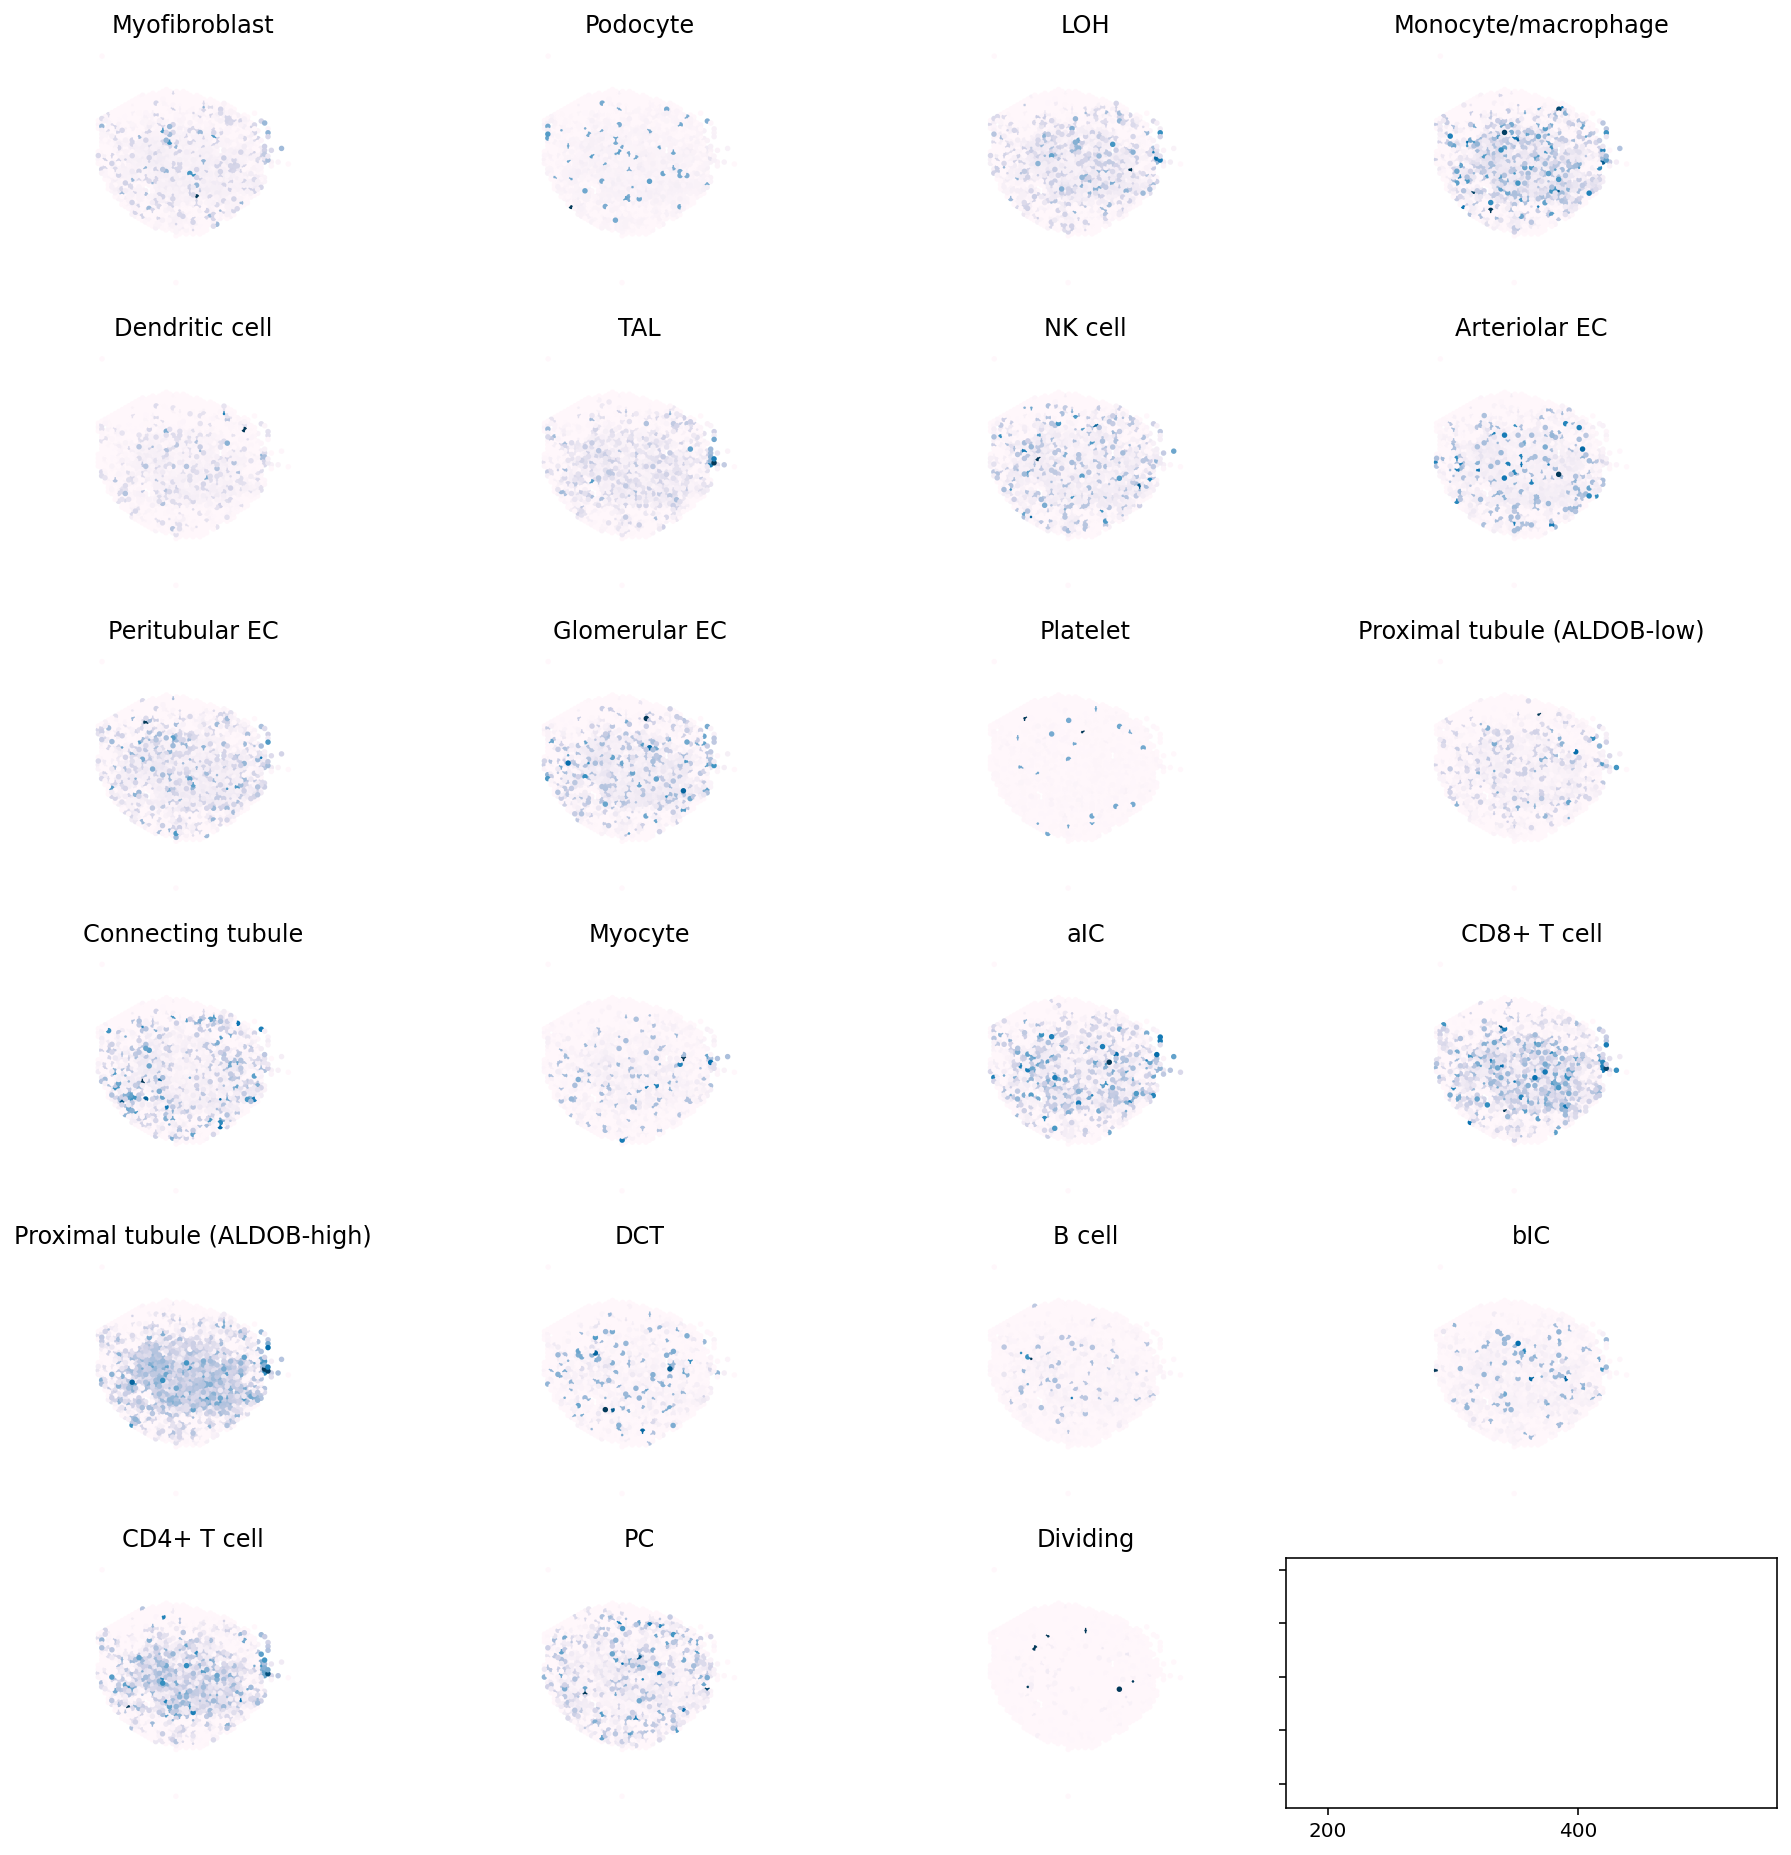

In [19]:
cell_types = list(ad_sc_fl.obs['subsampling.label'].unique())

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(13, 13), sharex=True, sharey=True)
for ax, ct in zip(axs.flatten(), cell_types):
    ax.scatter(x=ad_sp_fl.obs.x_lo, 
               y=ad_sp_fl.obs.y_lo, 
               c=prob_assign[ct], 
               s=3, 
               cmap='PuBu');
    ax.set_title(ct)
    ax.set_aspect(1)
    ax.axis('off');
plt.tight_layout()